# **Setup**

In [ ]:
!pip uninstall -y tensorflow estimator keras

Found existing installation: tensorflow 2.11.0
Uninstalling tensorflow-2.11.0:
  Successfully uninstalled tensorflow-2.11.0
Found existing installation: keras 2.11.0
Uninstalling keras-2.11.0:
  Successfully uninstalled keras-2.11.0


In [ ]:
!pip install -U tensorflow_text tensorflow tensorflow_datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 28.9 MB/s eta 0:00:00


In [ ]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 2.2 MB/s eta 0:00:00


#**Import Thư viện cần thiết**

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
import pathlib



plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

#**Tải dataset**

In [ ]:
path = 'flickr8k'
path = pathlib.Path(path)

tf.keras.utils.get_file(
    origin='https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip',
    cache_dir='.',
    cache_subdir=path,
    extract=True)
tf.keras.utils.get_file(
    origin='https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip',
    cache_dir='.',
    cache_subdir=path,
    extract=True)

2340801/2340801 [==============================] - 0s 0us/step


'./flickr8k/Flickr8k_text.zip'

In [ ]:
captions = (path/"Flickr8k.token.txt").read_text().splitlines()
def make_dataset(captions):
  df = []
  cap = [line.split('\t') for line in captions]
  i = 0
  for image, caption in cap:
    image = image.split('#')[0]
    if len(image.split(".")) <=2:
      df.append([i, str(path/"Flicker8k_Dataset"/image), caption])
    i +=1
  return df

#**Visualize Dataset**

In [ ]:
df = make_dataset(captions)

In [ ]:
data = pd.DataFrame(df, columns = ["index","image",  "caption"])

In [ ]:
data.head(5)

,index,image,caption
0,0,flickr8k/Flicker8k_Dataset/1000268201_693b08cb...,A child in a pink dress is climbing up a set o...
1,1,flickr8k/Flicker8k_Dataset/1000268201_693b08cb...,A girl going into a wooden building .
2,2,flickr8k/Flicker8k_Dataset/1000268201_693b08cb...,A little girl climbing into a wooden playhouse .
3,3,flickr8k/Flicker8k_Dataset/1000268201_693b08cb...,A little girl climbing the stairs to her playh...
4,4,flickr8k/Flicker8k_Dataset/1000268201_693b08cb...,A little girl in a pink dress going into a woo...


In [ ]:
from collections import Counter
def check_data(data):
  unique_file = np.unique(data.image.values)
  same_file = Counter(data.image.values)
  return unique_file, same_file

In [ ]:
unique_file, same_file = check_data(data)
print("Số lượng file ảnh khác nhau: ", len(unique_file))
print("Mỗi file ảnh có số caption: ", same_file)

Số lượng file ảnh khác nhau:  8091
Mỗi file ảnh có số caption:  Counter({'flickr8k/Flicker8k_Dataset/1000268201_693b08cb0e.jpg': 5, 'flickr8k/Flicker8k_Dataset/1001773457_577c3a7d70.jpg': 5, 'flickr8k/Flicker8k_Dataset/1002674143_1b742ab4b8.jpg': 5, 'flickr8k/Flicker8k_Dataset/1003163366_44323f5815.jpg': 5, 'flickr8k/Flicker8k_Dataset/1007129816_e794419615.jpg': 5, 'flickr8k/Flicker8k_Dataset/1007320043_627395c3d8.jpg': 5, 'flickr8k/Flicker8k_Dataset/1009434119_febe49276a.jpg': 5, 'flickr8k/Flicker8k_Dataset/1012212859_01547e3f17.jpg': 5, 'flickr8k/Flicker8k_Dataset/1015118661_980735411b.jpg': 5, 'flickr8k/Flicker8k_Dataset/1015584366_dfcec3c85a.jpg': 5, 'flickr8k/Flicker8k_Dataset/101654506_8eb26cfb60.jpg': 5, 'flickr8k/Flicker8k_Dataset/101669240_b2d3e7f17b.jpg': 5, 'flickr8k/Flicker8k_Dataset/1016887272_03199f49c4.jpg': 5, 'flickr8k/Flicker8k_Dataset/1019077836_6fc9b15408.jpg': 5, 'flickr8k/Flicker8k_Dataset/1019604187_d087bf9a5f.jpg': 5, 'flickr8k/Flicker8k_Dataset/1020651753_06077

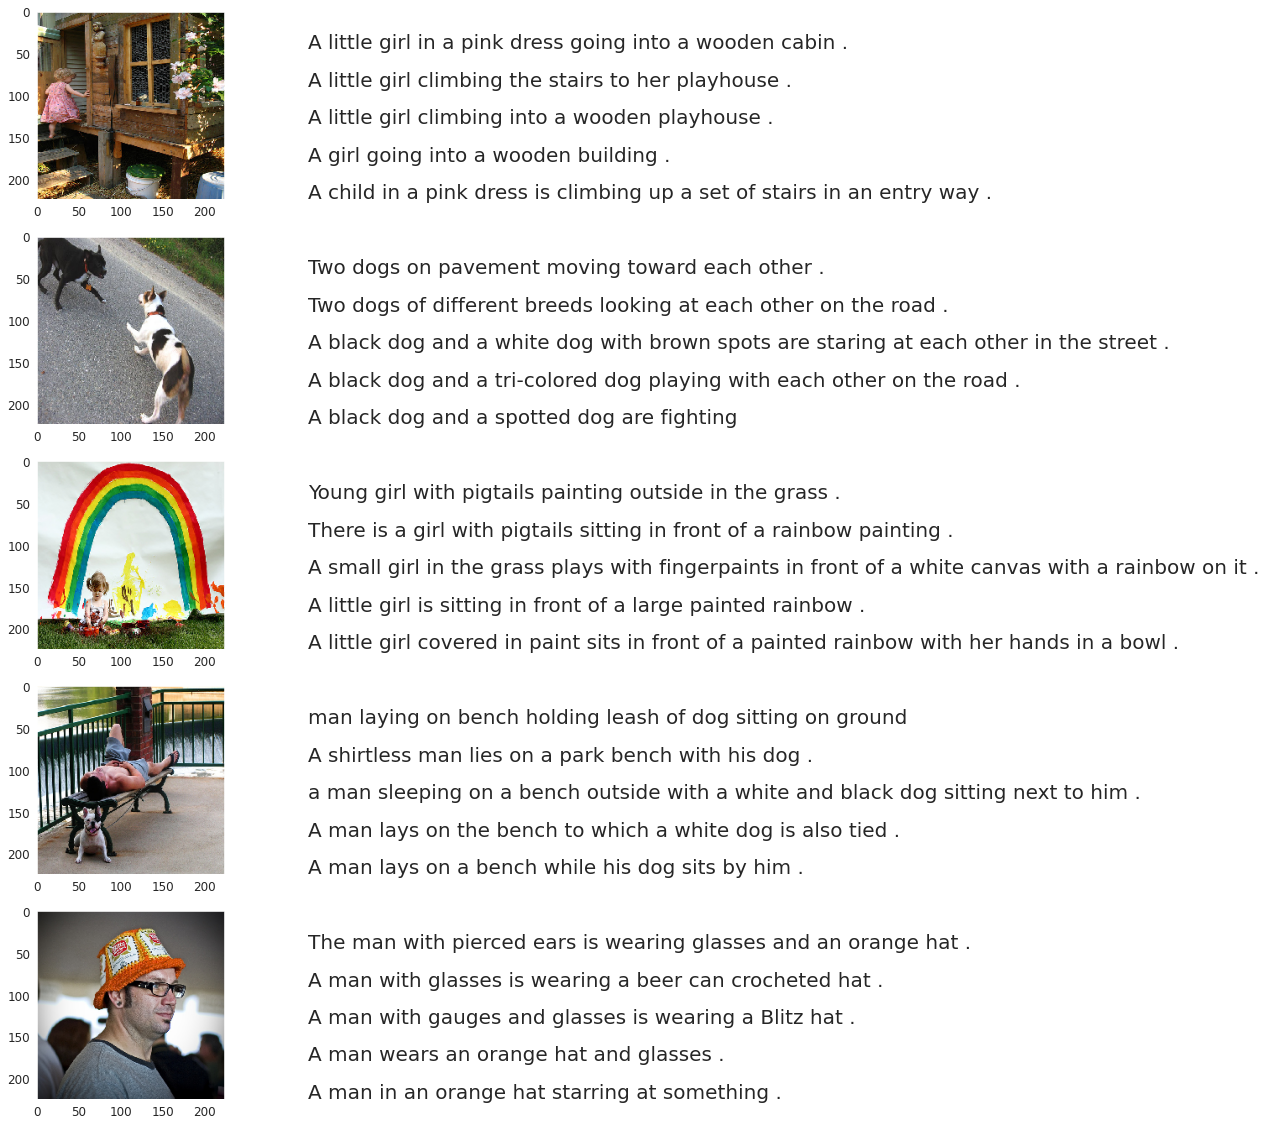

In [ ]:
npic = 5
npix = 224
target_size = (npix, npix,3)
count = 1
fig = plt.figure(figsize = (10,20))
for jpgfnm in unique_file[:5]:
  filename = str(jpgfnm)
  captions = list(data["caption"].loc[data["image"] == jpgfnm].values)
  image_load = tf.keras.utils.load_img(filename, target_size = target_size)
  ax = fig.add_subplot(npic,2,count)
  ax.imshow(image_load)
  count +=1
  ax = fig.add_subplot(npic, 2, count)
  plt.axis('off')
  ax.plot()
  ax.set_xlim(0,1)
  ax.set_ylim(0, len(captions))
  for i, caption in enumerate(captions):
    ax.text(0,i,caption, fontsize = 20)
  count += 1
plt.show()

#**Tokenization and Encoded Representation**

In [ ]:
#Xử lí text:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

In [ ]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

# **Chia tập train, test validation**

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()j
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

#**Trích xuất đặc trưng ảnh**

In [ ]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

82524592/82524592 [==============================] - 1s 0us/step


100%|██████████| 8091/8091 [14:24<00:00,  9.36it/s]


#**Data Generation**

In [ ]:
class CustomDataGenerator(Sequence):

    def __init__(self, df, X_col, y_col, batch_size, tokenizer,
                 vocab_size, max_length, features,shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self,batch):

        X1, X2, y = list(), list(), list()

        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image][0]

            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)

        return X1, X2, y

#**Modelling**

## **LSTM without Attention**

In [ ]:
def LSTM_without_Attention():
  input1 = Input(shape=(1920,))
  input2 = Input(shape=(max_length,))

  img_features = Dense(256, activation='relu')(input1)
  img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

  sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
  merged = concatenate([img_features_reshaped,sentence_features],axis=1)
  sentence_features = LSTM(256)(merged)
  x = Dropout(0.5)(sentence_features)
  x = add([x, img_features])
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.5)(x)
  output = Dense(vocab_size, activation='softmax')(x)

  caption_model = Model(inputs=[input1,input2], outputs=output)
  caption_model.compile(loss='categorical_crossentropy',optimizer='adam')
  return caption_model

In [ ]:
caption_model = LSTM_without_Attention()

In [ ]:
caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1920)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          491776      ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 reshape (Reshape)              (None, 1, 256)       0           ['dense[0][0]']                  
                                                                                            

In [ ]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [ ]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)
#overfitting
earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)
#Lớp ReduceLROnPlateau để giảm tỷ lệ học (learning rate) nếu không có sự cải thiện nào trong quá trình huấn luyện.
#Lớp này sẽ giảm tỷ lệ học theo một hệ số giảm (factor) khi không có sự cải thiện nào sau một số lần lặp (patience).
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

In [ ]:
caption_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1920)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          491776      ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 reshape (Reshape)              (None, 1, 256)       0           ['dense[0][0]']                  
                                                                                            

## **Train model**

In [ ]:
history = caption_model.fit(
        train_generator,
        epochs=10,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])


Epoch 1/10
537/537 [==============================] - ETA: 0s - loss: 5.1314
Epoch 1: val_loss improved from inf to 4.27549, saving model to model.h5
537/537 [==============================] - 248s 452ms/step - loss: 5.1314 - val_loss: 4.2755 - lr: 0.0010
Epoch 2/10
537/537 [==============================] - ETA: 0s - loss: 4.1976
Epoch 2: val_loss improved from 4.27549 to 3.93706, saving model to model.h5
537/537 [==============================] - 68s 127ms/step - loss: 4.1976 - val_loss: 3.9371 - lr: 0.0010
Epoch 3/10
537/537 [==============================] - ETA: 0s - loss: 3.9273
Epoch 3: val_loss improved from 3.93706 to 3.77775, saving model to model.h5
537/537 [==============================] - 51s 95ms/step - loss: 3.9273 - val_loss: 3.7777 - lr: 0.0010
Epoch 4/10
537/537 [==============================] - ETA: 0s - loss: 3.7672
Epoch 4: val_loss improved from 3.77775 to 3.69767, saving model to model.h5
537/537 [==============================] - 51s 94ms/step - loss: 3.7672 -

## **Predict tập test**

In [ ]:
def idx_to_word(integer,tokenizer):
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [ ]:
def predict_caption(model, image, tokenizer, max_length, features):

    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)

        word = idx_to_word(y_pred, tokvenizer)

        if word is None:
            break

        in_text+= " " + word

        if word == 'endseq':
            break

    return in_text

In [ ]:
samples = test.sample(100)
samples.reset_index(drop=True,inplace=True)

In [ ]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.

    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption

1/1 [==============================] - 0s 22ms/step


## **Bleu Score**

In [ ]:
import numpy as np
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
def bleu_score(real, pred):
    """
    Tính toán Bleu Score cho một tập các câu mô tả.

    Args:
        references: list of list of str. Danh sách các câu mô tả thực tế cho tập ảnh đầu vào.
        hypotheses: list of str. Danh sách các câu mô tả được sinh ra bởi mô hình cho tập ảnh đầu vào.

    Returns:
        float. Giá trị Bleu Score trung bình cho tất cả các câu mô tả trong tập ảnh đầu vào.
    """
    bleu_scores = []
    for i in range(len(pred)):
        real_one = real[i]
        pred_one = pred[i]
        #print(pred)
        # Tách các từ trong câu mô tả thực tế và câu mô tả được sinh ra.
        pred_one= [pred_one.split()]
        #print(real)
        bleu = []
        for j in real_one:
          real_one_sen = j.split()
          #print(real_one_sen)
          bleu.append(sentence_bleu(pred_one, real_one_sen, smoothing_function=SmoothingFunction().method4)*100)
        average = np.mean(bleu)
        bleu_scores.append(average)
        #break
    # Tính toán giá trị Bleu Score trung bình.
    bleu_scores = np.array(bleu_scores)
    average_bleu_score = np.mean(bleu_scores)
    return average_bleu_score


In [ ]:
unique_file_test, _ = check_data(test)

array(['flickr8k/Flicker8k_Dataset/3688858505_e8afd1475d.jpg',
       'flickr8k/Flicker8k_Dataset/3689355450_fd559b816d.jpg',
       'flickr8k/Flicker8k_Dataset/368954110_821ccf005c.jpg',
       'flickr8k/Flicker8k_Dataset/3689727848_b53f931130.jpg',
       'flickr8k/Flicker8k_Dataset/3689975998_72f50b6d91.jpg'],
      dtype=object)

In [ ]:
len(unique_file_test)

1214

In [ ]:
captions = []
image = []
for jpgfnm in unique_file_test:
  filename = str(jpgfnm)
  captions.append((test["caption"].loc[test["image"] == jpgfnm].values))
  image.append(filename)

image = image[:1000]
captions = captions[:1000]
captions_pred = []
for i in image:
  img = load_img(os.path.join(i),target_size=(224,224))
  img = img_to_array(img)
  img = img/255.
  captions_pred.append(predict_caption(caption_model, i, tokenizer, max_length, features))


Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
1/1 [==============================] - 0s 36ms/step


In [ ]:
bleu_score(captions, captions_pred)

6.177197728125573

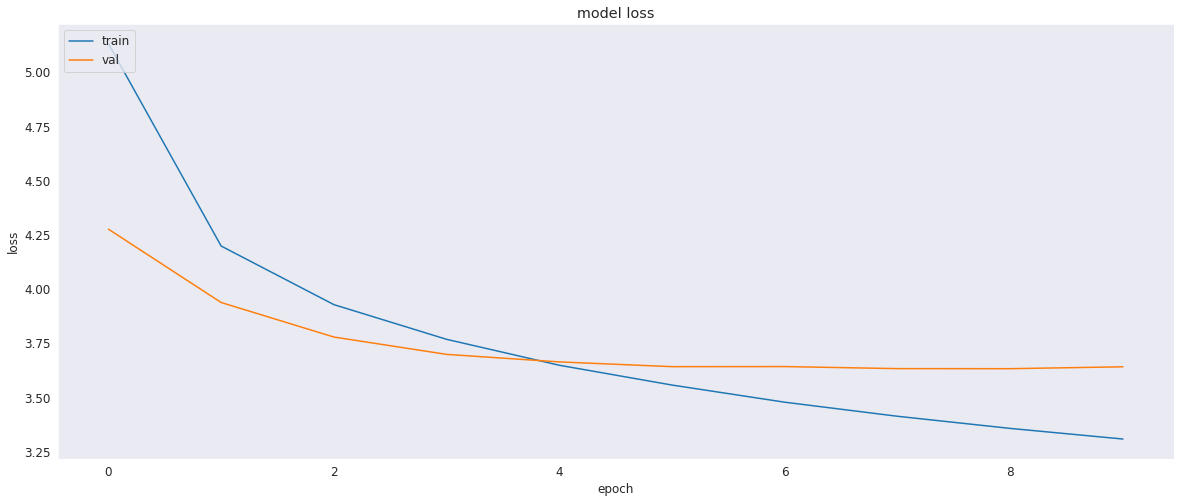

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## **Visualize dự đoán 15 ảnh ngẫu nhiên từ Test**

In [ ]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    return img

In [ ]:
def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(temp_df.image[i])
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

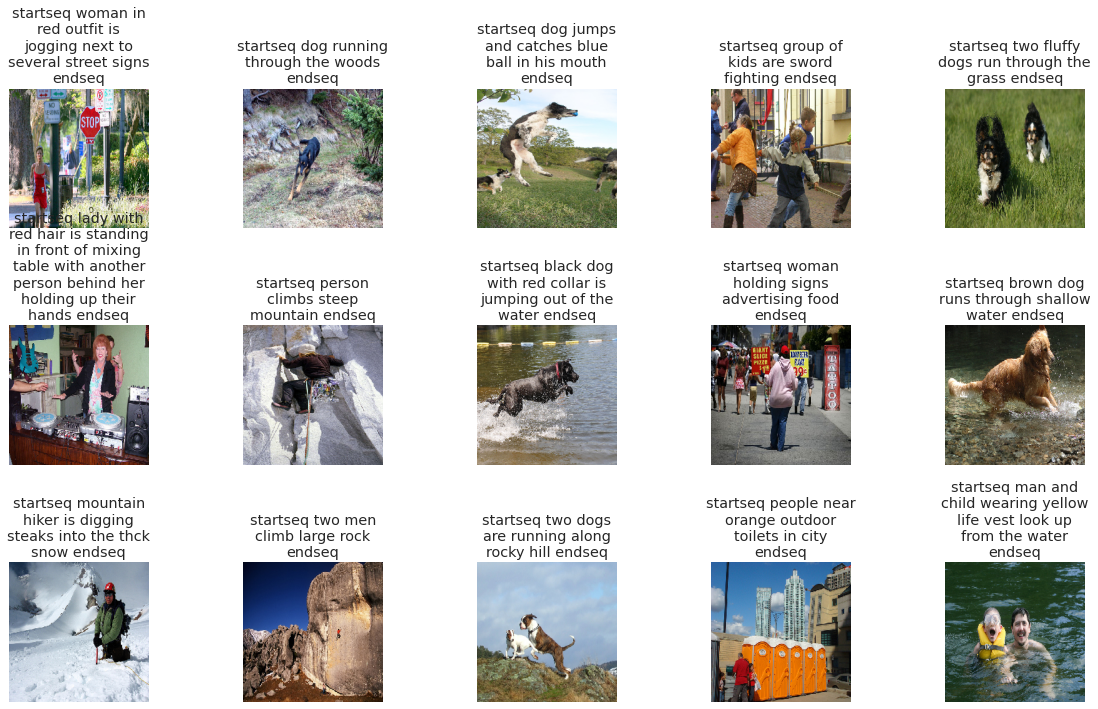

In [ ]:
display_images(test.sample(15))